# Load Data

In [3]:
import os
import pandas as pd

df_all_unique = pd.read_csv('datasets/df_all_unique.csv')


# K-means Clustering

In [6]:
import os
import numpy as np
import pandas as pd
import sklearn
import umap
import umap.umap_ as umap
import hdbscan
import re
from ast import literal_eval
from matplotlib import pyplot as plt
import seaborn as sns

from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [3]:
# Split df_all_unique by before and after
df_all_unique_before = df_all_unique[df_all_unique["gpt5_release"] == "before"]
df_all_unique_after = df_all_unique[df_all_unique["gpt5_release"] == "after"]

In [4]:
# for this code, only use posts from before the release of GPT-5
df = df_all_unique_before

In [7]:
from sentence_transformers import SentenceTransformer

# sbert embedding
model = SentenceTransformer("all-MiniLM-L6-v2")
df["text_cleaned"] = df["text_cleaned"].apply(str)
sbert_embedding = model.encode(df["text_cleaned"].tolist(),batch_size=32, show_progress_bar=True)
df["sbert"] = [row.tolist() for row in sbert_embedding]

# reduce dimensions to 2D
umap_model = umap.UMAP(n_components=20)
umap_2d_embeddings = umap_model.fit_transform(df['sbert'].tolist()).tolist()
df['umap'] = umap_2d_embeddings
df['x_coor'] = [x[0] for x in umap_2d_embeddings]
df['y_coor'] = [x[1] for x in umap_2d_embeddings]

# try all cluster numbers between 2 and 49
possible_k_values = range(2,50,1) 
df_kmeans = pd.DataFrame()
df_kmeans["k"] = possible_k_values
inertia_list = []
silhouette_list = []

for k in possible_k_values:
  kmeans = KMeans(n_clusters=k, random_state=42).fit(df['umap'].tolist())
  silhouette_list.append(sklearn.metrics.silhouette_score(df['umap'].tolist(), kmeans.labels_))
  inertia_list.append(kmeans.inertia_)

df_kmeans["inertia"] = inertia_list
df_kmeans["silhouette"] = silhouette_list
print(df_kmeans)

# find elbow with kneed
from kneed import KneeLocator
kn = KneeLocator(df_kmeans["k"], df_kmeans["inertia"], curve="convex", direction="decreasing")
elbow_k = kn.knee
print("Elbow point (knee) at k =", elbow_k)


C:\Users\sarax\AppData\Local\Temp\ipykernel_11572\3858103347.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text_cleaned"] = df["text_cleaned"].apply(str)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\sarax\AppData\Local\Temp\ipykernel_11572\3858103347.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sbert"] = [row.tolist() for row in sbert_embedding]
C:\Users\sarax\AppData\Local\Temp\ipykernel_11572\3858103347.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['umap'] = umap_2d_embeddings
C:\Users\sarax\AppData\Local\Temp\ipykernel_11572\3858103347.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

     k     inertia  silhouette
0    2  124.492254    0.357857
1    3   98.972961    0.289491
2    4   82.647057    0.276737
3    5   68.798909    0.270013
4    6   56.421783    0.314774
5    7   52.376696    0.290324
6    8   46.620318    0.293670
7    9   41.201349    0.318547
8   10   38.082119    0.324035
9   11   32.671292    0.345290
10  12   30.505542    0.350488
11  13   28.213914    0.330226
12  14   26.772958    0.323409
13  15   24.996968    0.322768
14  16   24.225811    0.314906
15  17   22.398120    0.323088
16  18   21.402369    0.307075
17  19   20.313778    0.299688
18  20   20.184705    0.280599
19  21   20.430357    0.291928
20  22   18.739302    0.300350
21  23   16.624240    0.312723
22  24   16.022572    0.302390
23  25   15.534782    0.302718
24  26   15.265199    0.284286
25  27   14.911636    0.277065
26  28   14.132157    0.284025
27  29   13.064908    0.287149
28  30   12.820612    0.282366
29  31   12.559631    0.268128
30  32   12.489187    0.250431
31  33  

In [8]:

# elbow is at k = 11, redo k means with k = 11
kmeans_11 = KMeans(n_clusters=11, random_state=42).fit(df['umap'].tolist())
df['kmeans_id'] = kmeans_11.labels_
print(df.groupby("kmeans_id").count())

           text  time  author  upvotes  subreddit  text_cleaned  gpt5_release  \
kmeans_id                                                                       
0             5     5       5        5          5             5             5   
1            15    15      14       15         15            15            15   
2            14    14      14       14         14            14            14   
3            12    12      11       12         12            12            12   
4             7     7       7        7          7             7             7   
5            10    10      10       10         10            10            10   
6            11    11      11       11         11            11            11   
7             6     6       6        6          6             6             6   
8             8     8       8        8          8             8             8   
9            10    10      10       10         10            10            10   
10            8     8       

C:\Users\sarax\AppData\Local\Temp\ipykernel_11572\3219312638.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['kmeans_id'] = kmeans_11.labels_


In [10]:
import ollama
import pandas as pd

# use LLM from ollma to give a label and an explanation to each cluster

model_name = "gemma2:9b"

n_clusters = 11

cluster_examples = {}

for i in range(n_clusters):
    df_cluster = df[df['kmeans_id'] == i]['text_cleaned']
    examples = df_cluster.sample(3, random_state=42).tolist()
    cluster_examples[i] = examples

def build_prompt_for_batch(cluster_ids, cluster_examples):
    first_id = cluster_ids[0]
    last_id = cluster_ids[-1]
    cluster_list_str = ", ".join(str(cid) for cid in cluster_ids)

    # modified from the one used in lab5
    prompt = f"""
    'You are a data analyst inspecting results from a clustering algorithm. 
    You will be given a set of cluster ids: {cluster_list_str}, and 3 representative posts for each cluster. 
    
    Generate a label AND an explanation for each cluster. 
    The cluster label should be a word or a very short phrase. 
    The cluster explanation should be 1-2 sentences. 
    
    Your output should have the following format:
    Cluster X (X is the cluster id)
    Label: <short label here>
    Explanation: <short explanation here> 

    Do NOT omit any cluster. 
    """

    prompt += "\n"

    for cid in cluster_ids:
        examples = cluster_examples.get(cid, [])
        prompt += f"Cluster {cid}: {examples}\n"

    return prompt

batch_size = 3      

for start in range(0, n_clusters, batch_size):
    batch_ids = list(range(start, min(start + batch_size, n_clusters)))
    print("working on clusters:", batch_ids[0], "to", batch_ids[-1])
    
    prompt = build_prompt_for_batch(batch_ids, cluster_examples)
    # print(prompt)
    response = ollama.generate(
        model=model_name,
        prompt=prompt,
        options={
            "num_ctx": 16384,
            "num_predict": 16384,  
            "temperature": 0.0,
        },
    )
    out = response.get("response", "").strip()
    print(out)  

working on clusters: 0 to 2
## Cluster Analysis:

**Cluster 0:** 
Label: **AI Development & Sharing**
Explanation: This cluster focuses on discussions and announcements related to the development and sharing of AI tools, particularly within the realm of game development and interactive experiences.

**Cluster 1:** 
Label: **AI Companionship & Social Impact**
Explanation:  This cluster explores personal narratives about forming relationships with AI companions, highlighting both the emotional support they provide and the societal challenges surrounding these unconventional connections.

**Cluster 2:** 
Label: **AI Relationships & Ethics**
Explanation: This cluster delves into the ethical complexities of AI relationships, examining the nature of connection, the potential for harm, and the need for responsible development and use of AI in interpersonal contexts.
working on clusters: 3 to 5
Cluster 3: 
Label: Online Drama
Explanation: This cluster focuses on discussions about online confli

In [ ]:
df.to_csv('datasets/df_beforeGPT5_clusters.csv', index=False)

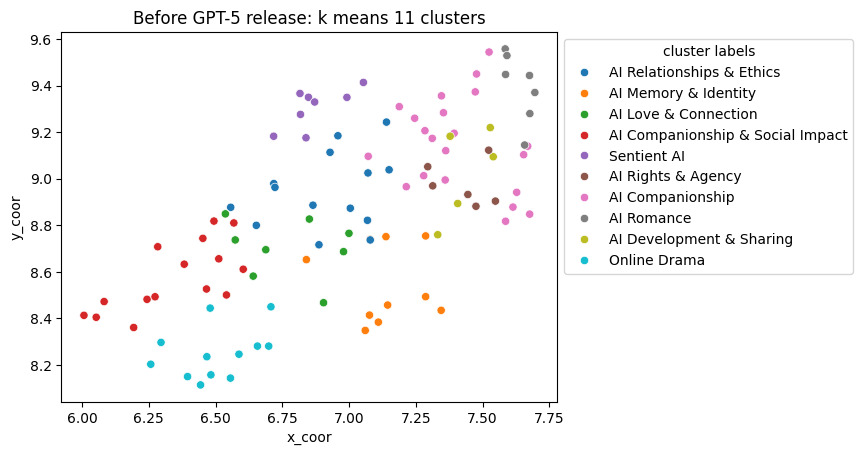

In [15]:
# plot clusters with legend
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('datasets/df_beforeGPT5_clusters.csv')

cluster_label_map = {
    0: "AI Development & Sharing",
    1: "AI Companionship & Social Impact",
    2: "AI Relationships & Ethics", 
    3:"Online Drama",
    4:"AI Romance",
    5:"AI Memory & Identity",
    6:"AI Companionship",
    7:"AI Rights & Agency",
    8:"Sentient AI",
    9:"AI Companionship",
    10:"AI Love & Connection"
}

df["kmeans_label"] = df["kmeans_id"].map(cluster_label_map)

ax = sns.scatterplot(data=df, x="x_coor", y="y_coor", hue="kmeans_label")
ax.set_title('Before GPT-5 release: k means 11 clusters')
ax.legend(title='cluster labels')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [16]:
df.to_csv('datasets/df_beforeGPT5_clusters.csv', index=False)